In [1]:
%load_ext autoreload
%autoreload 2
## Import packages
import pandas as pd  # For file input/output
from scipy import optimize
from scipy.special import softmax
from scipy.optimize._numdiff import approx_derivative
import numpy as np
import sys
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import hyperopt

# append a new directory to sys.path
sys.path.append('../rumboost and RUMs/')

from datasets import load_preprocess_LPMC
from rumbooster import rum_train
from utils import bio_to_rumboost
from models import LPMC_synthetic
from benchmarks import prepare_model, estimate_models
from function_smoothing import data_leaf_value, optimal_knots_position, map_x_knots, monotone_spline

## Semi-synthetic dataset

In [134]:
dataset_train, _, _ = load_preprocess_LPMC()

dataset_train['dur_pt'] = dataset_train['dur_pt_int_waiting'] + dataset_train['dur_pt_int_walking'] + dataset_train['dur_pt_access'] + dataset_train['dur_pt_rail'] + dataset_train['dur_pt_bus']

dataset_train = pd.concat([dataset_train]*5).reset_index(drop=True)

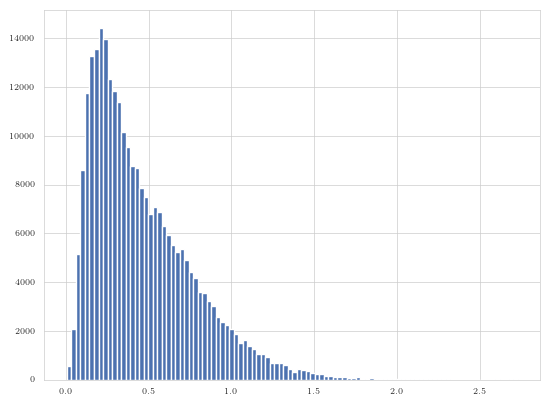

In [135]:
plt.hist(dataset_train['dur_pt'], bins=100)
plt.show()

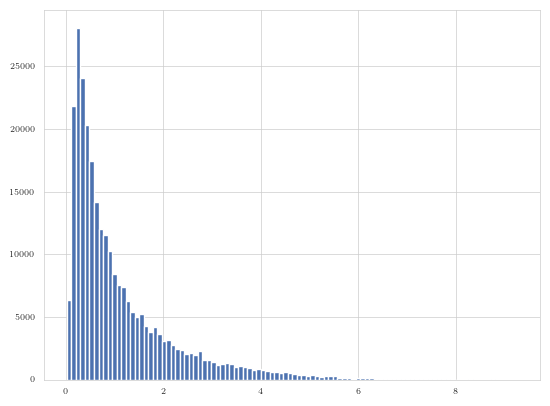

In [136]:
plt.hist(dataset_train['dur_walking'], bins=100)
plt.show()

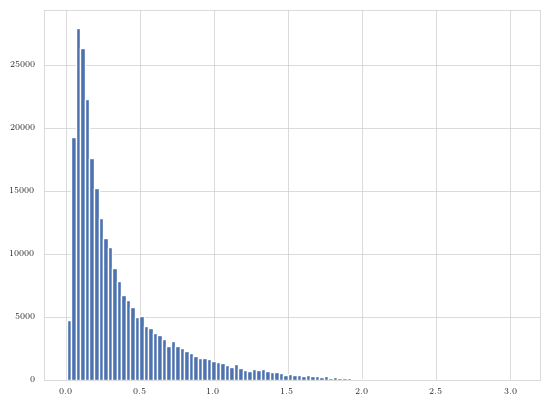

In [137]:
plt.hist(dataset_train['dur_cycling'], bins=100)
plt.show()

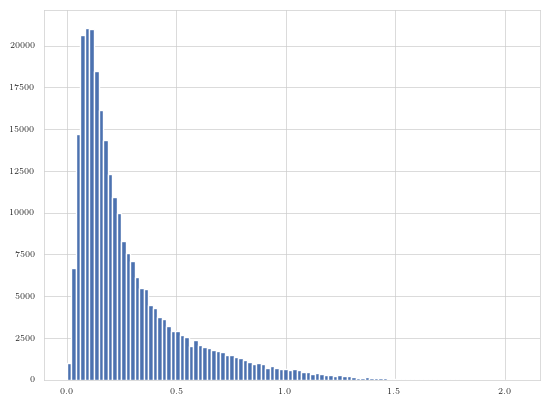

In [138]:
plt.hist(dataset_train['dur_driving'], bins=100)
plt.show()

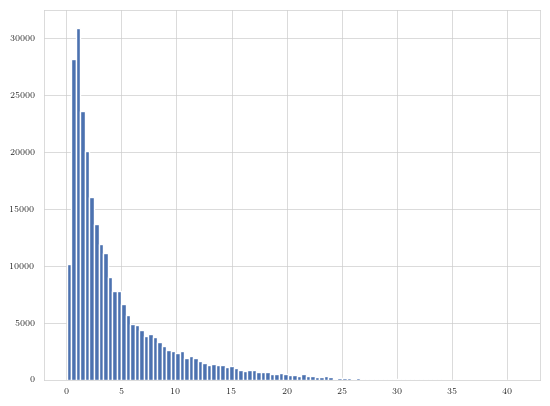

In [139]:
plt.hist(dataset_train['distance'], bins=100)
plt.show()

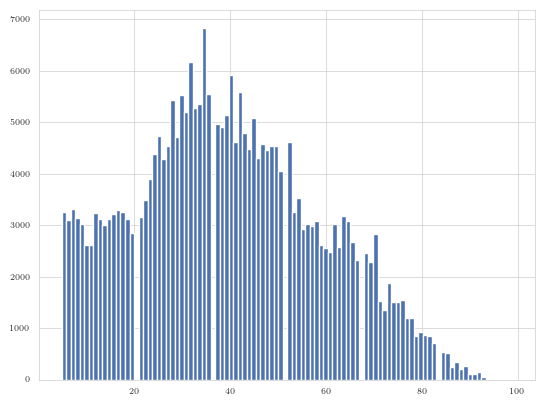

In [140]:
plt.hist(dataset_train['age'], bins=100)
plt.show()

In [152]:
np.random.seed(1)

n_alternatives = 4

def create_discontinuity(x, x_disc, jump):
    return np.where(x < x_disc, x, 0.5*(x-x_disc) + x_disc+jump)

# Define the utility function
def utility_function_LPMC(data):
    # Extract the parameters
    V = np.zeros((data.shape[0], n_alternatives))

    V[:, 0] = 0.6 + -1 * np.log(data['dur_walking']+1) + 1/1000 * create_discontinuity(data['age'], 50, 4) * create_discontinuity(data['distance'], 30, 1)
    V[:, 1] = 0.3 + -1 * data['dur_cycling'] + 1/1000 * create_discontinuity(data['age'], 50, 4) * create_discontinuity(data['distance'], 30, 1)
    V[:, 2] = 0.1 + -1/10 * data['dur_pt']**2 + 1/1000 * create_discontinuity(data['age'], 50, 4) * create_discontinuity(data['distance'], 30, 1)
    V[:, 3] = 0 + -1/2 * create_discontinuity(data['dur_driving'], 1, 3) + 1/1000 * create_discontinuity(data['age'], 50, 4) * create_discontinuity(data['distance'], 30, 1)

    return V

def utility_function_synthetic(data, num_points=100000):
    # Extract the parameters
    new_data = pd.DataFrame()
    new_data['new_dur_walking'] = np.linspace(data['dur_walking'].min(), data['dur_walking'].max(), num_points)
    new_data['new_dur_pt'] = np.linspace(data['dur_pt'].min(), data['dur_pt'].max(), num_points)
    new_data['new_dur_cycling'] = np.linspace(data['dur_cycling'].min(), data['dur_cycling'].max(), num_points)
    new_data['new_dur_driving'] = np.linspace(data['dur_driving'].min(), data['dur_driving'].max(), num_points)
    new_data['new_age'] = np.linspace(data['age'].min(), data['age'].max(), num_points)
    new_data['new_distance'] = np.linspace(data['distance'].min(), data['distance'].max(), num_points)
    V = np.zeros((num_points, n_alternatives))

    V[:, 0] = 0.6 + -1 * np.log(new_data['new_dur_walking']+1) + 1/1000 * create_discontinuity(new_data['new_age'], 50, 4) * create_discontinuity(new_data['new_distance'], 30, 1)
    V[:, 1] = 0.3 + -1 * new_data['new_dur_cycling'] + 1/1000 * create_discontinuity(new_data['new_age'], 30, 4) * create_discontinuity(new_data['new_distance'], 20, 1)
    V[:, 2] = 0.1 + -1/3 * new_data['new_dur_pt']**2 + 1/1000 * create_discontinuity(new_data['new_age'], 20, 4) * create_discontinuity(new_data['new_distance'], 10, 1)
    V[:, 3] = 0 + -1/2 * create_discontinuity(new_data['new_dur_driving'], 1, 3) + 1/1000 * create_discontinuity(new_data['new_age'], 60, 4) * create_discontinuity(new_data['new_distance'], 5, 1)

    return V, new_data

# Define the utility function
def simpler_utility_function(data):
    # Extract the parameters
    V = np.zeros((data.shape[0], n_alternatives))

    V[:, 0] = 0.6 + -1 * np.log(data['dur_walking']+1) 
    V[:, 1] = 0.3 + -1/100 * data['dur_cycling'] * data['age']
    V[:, 2] = 0.2 + -1/3 * data['dur_pt']**2 
    V[:, 3] = 0 + -1/2 * create_discontinuity(data['dur_driving'], 1, 3)

    return V

def noise(mean, sd, n):
    return np.random.gumbel(loc=mean, scale=sd, size=n)

def compute_prob(V):

    return softmax(V, axis=1)

def generate_labels(probs):
    labels = [np.random.choice(range(n_alternatives), p=probs[i]) for i in range(probs.shape[0])]
    return np.array(labels)

def log(x):
    return -1 * np.log(x + 1)

def linear(x):
    return -1 * x

def x_squared(x):
    return -1/3 * x**2

def disc(x): 
    return -1/2 * create_discontinuity(x, 1, 3)

def null(x):
    return np.zeros_like(x)


### calibration

In [153]:
np.log(dataset_train['dur_walking']+1).max()

2.3300381197429156

In [154]:
np.exp(dataset_train['dur_cycling']).max()

21.156441970302357

In [155]:
(dataset_train['dur_pt']**2).max()

7.4529

In [156]:
((dataset_train['age']- dataset_train['age'].mean())**2 * dataset_train['distance']).max()/20000

2.6477055399878067

In [157]:
(dataset_train['age'].values * dataset_train['dur_cycling'].values).max()

152.100555546

## simpler RUMBoost

In [158]:
np.random.seed(1)
V_train = simpler_utility_function(dataset_train)
#V_train, new_data_train = utility_function_synthetic(dataset_train, num_points=500000)
probs_train = softmax(V_train, axis=1)
#eps = noise(0, 0.05, V_train.shape)
#probs_train = softmax(V_train + eps, axis=1)
y_train = generate_labels(probs_train)

In [181]:

rum_structure = [{'columns': ['dur_walking'],
                 'monotone_constraints': [-1],
                 'interaction_constraints': [[0]]},
                 {'columns': ['dur_cycling', 'age'],
                 'monotone_constraints': [-1, -1],
                 'interaction_constraints': [[0, 1]]},
                 {'columns': ['dur_pt'],
                 'monotone_constraints': [-1],
                 'interaction_constraints': [[0]]},
                 {'columns': ['dur_driving', 'distance'],
                 'monotone_constraints': [-1, 0],
                 'interaction_constraints': [[0], [1]]}]
#parameters
params = {'n_jobs': -1,
          'num_classes':4, #important
          'objective':'multiclass',
          'boosting': 'gbdt',
          'monotone_constraints_method': 'advanced',
          'verbosity': 1,
          'num_iterations':1500,
          'early_stopping_round':100,
          'learning_rate':0.1,
          'max_bin':10000,
          'max_depth':2 #important to let it at 1 so that the model can split on many different features.
          }

train_set = lgb.Dataset(dataset_train[['dur_walking', 'dur_cycling', 'dur_pt', 'dur_driving', 'age', 'distance']], label=y_train, free_raw_data=False)
#valid_set = lgb.Dataset(dataset_test[['TRAIN_TT', 'TRAIN_COST', 'TRAIN_HE', 'SM_TT', 'SM_COST', 'SM_HE', 'CAR_TT', 'CAR_CO']], label=y_test, free_raw_data=False)
rum_model = rum_train(params, train_set, rum_structure, valid_sets=[train_set])


c:\Users\DAF1\OneDrive - University College London\Documents\PhD - UCL\prediction-behavioural-analysis-ml-travel-mode-choice\../GBM feature extraction/Multiclass problem\rumbooster.py:2188: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1] -- NCE value on train set: 1.3836762620894172
[11] -- NCE value on train set: 1.371757515696299
[21] -- NCE value on train set: 1.3690642494630652
[31] -- NCE value on train set: 1.368215827575249
[41] -- NCE value on train set: 1.367868660214067
[51] -- NCE value on train set: 1.3676756912032086
[61] -- NCE value on train set: 1.3675477664872033
[71] -- NCE value on train set: 1.3674522626828842
[81] -- NCE value on train set: 1.3673751100073732
[91] -- NCE value on train set: 1.3673136686695158
[101] -- NCE value on train set: 1.3672645946469248
[111] -- NCE value on train set: 1.3672225157125466
[121] -- NCE value on train set: 1.367188769055433
[131] -- NCE value on train set: 1.367157959772128
[141] -- NCE value on train set: 1.3671312579453
[151] -- NCE value on train set: 1.3671083797628174
[161] -- NCE value on train set: 1.3670885619783326
[171] -- NCE value on train set: 1.3670686284830615
[181] -- NCE value on train set: 1.367050799821149
[191] -- NCE value on train set:

In [185]:
_, a, _ = rum_model.getweights_v2()

In [186]:
test_set = pd.DataFrame({'dur_walking': [0], 'dur_cycling': [0], 'dur_pt': [0], 'dur_driving': [0], 'age': [0], 'distance': [0]})

rum_model.predict(lgb.Dataset(test_set, free_raw_data=False), utilities=True) - 0.016

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.


array([[5.62707725e-01, 3.82403012e-01, 1.97005523e-01, 2.41744872e-04]])

In [183]:


param_space = {'0':{'dur_walking': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_walking', 3, 5,1))},
               '1':{},
            '2':{'dur_pt': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_pt', 3, 5,1))},
            '3':{'dur_driving': hyperopt.pyll.scope.int(hyperopt.hp.quniform('dur_driving', 3, 5,1))}
                }

def objective(space):

    weights = rum_model.weights_to_plot_v2()

    spline_utilities = {'0':['dur_walking'],'1':[], '2':['dur_pt'], '3': ['dur_driving']}

    spline_collection = space

    #x_opt, x_first, x_last, loss = optimal_knots_position(weights, dataset_train[0], dataset_train[0], y_train, spline_utilities, spline_collection, max_iter = 50, optimize = True, deg_freedom=True, n_iter=1)
    x_opt, _, _, loss = optimal_knots_position(weights, dataset_train, dataset_train, y_train, spline_utilities, spline_collection, max_iter = 50, optimize = True, deg_freedom=True, n_iter=1, linear_extrapolation=True)

    #return {'loss': loss, 'x_opt':x_opt.x, 'status': hyperopt.STATUS_OK, 'x_first': x_first, 'x_last': x_last}
    return {'loss': loss, 'x_opt':x_opt.x, 'status': hyperopt.STATUS_OK}

n = 25

time_init = time.perf_counter()
trials = hyperopt.Trials()
best_classifier = hyperopt.fmin(fn=objective,
                                space=param_space,
                                algo=hyperopt.tpe.suggest,
                                max_evals=n,
                                trials=trials)
elapsed_time = time.perf_counter() - time_init

best_classifier['_best_loss'] = trials.best_trial['result']['loss']
best_classifier['_elapsed_time'] = elapsed_time
best_classifier['_x_opt'] = trials.best_trial['result']['x_opt']

weights = rum_model.weights_to_plot_v2()

spline_collection = {'0':{'dur_walking': int(best_classifier['dur_walking'])},
                     '1': {},
            '2':{'dur_pt': int(best_classifier['dur_pt'])},
            '3':{'dur_driving': int(best_classifier['dur_driving'])}
                }
#spline_utilities = {'0':['distance', 'dur_walking'],'1':['distance', 'dur_cycling'], '2':['distance', 'dur_pt_rail', 'dur_pt_bus', 'cost_transit', 'dur_pt_int_waiting', 'dur_pt_int_walking', 'dur_pt_access'], '3': ['distance', 'dur_driving','cost_driving_fuel', 'driving_traffic_percent']}
spline_utilities = {'0':['dur_walking'],'1':[], '2':['dur_pt'], '3': ['dur_driving']}
x_knots_dict = map_x_knots(trials.best_trial['result']['x_opt'], spline_collection)


  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

c:\Users\DAF1\anaconda3\anaconda3\envs\RUMBooster\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Optimization terminated successfully    (Exit mode 0) 
            Current function value:                   
749724.5445816286                                     
            Iterations:                               
13                                                    
            Function evaluations:                     
272                                                   
            Gradient evaluations:                     
12                                                    
1/1:749741.1934511318 with knots at: [2.53008672e-02 7.62254036e-01 1.52852626e+00 3.40604185e+00
 5.32214460e+00 7.12033040e-02 3.07412573e-01 5.00995744e-01
 6.94717425e-01 1.04397137e+00 1.47583299e+00 2.77778748e-04
 2.60800625e-01 6.06339549e-01 8.67110977e-01 1.24469316e+00]
Optimization terminated successfully    (Exit mode 0)                          
            Current function value:                                            
749629.1407940795                                              

c:\Users\DAF1\anaconda3\anaconda3\envs\RUMBooster\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Optimization terminated successfully    (Exit mode 0)                          
            Current function value:                                            
749724.5445816286                                                              
            Iterations:                                                        
13                                                                             
            Function evaluations:                                              
272                                                                            
            Gradient evaluations:                                              
12                                                                             
1/1:749741.1934511318 with knots at: [2.53008672e-02 7.62254036e-01 1.52852626e+00 3.40604185e+00
 5.32214460e+00 7.12033040e-02 3.07412573e-01 5.00995744e-01
 6.94717425e-01 1.04397137e+00 1.47583299e+00 2.77778748e-04
 2.60800625e-01 6.06339549e-01 8.67110977e-01 1.24469316e+00

c:\Users\DAF1\anaconda3\anaconda3\envs\RUMBooster\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Optimization terminated successfully    (Exit mode 0)                           
            Current function value:                                             
749724.5445816286                                                               
            Iterations:                                                         
13                                                                              
            Function evaluations:                                               
272                                                                             
            Gradient evaluations:                                               
12                                                                              
1/1:749741.1934511318 with knots at: [2.53008672e-02 7.62254036e-01 1.52852626e+00 3.40604185e+00
 5.32214460e+00 7.12033040e-02 3.07412573e-01 5.00995744e-01
 6.94717425e-01 1.04397137e+00 1.47583299e+00 2.77778748e-04
 2.60800625e-01 6.06339549e-01 8.67110977e-01 1.244

c:\Users\DAF1\anaconda3\anaconda3\envs\RUMBooster\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



Optimization terminated successfully    (Exit mode 0)                           
            Current function value:                                             
749749.2165849477                                                               
            Iterations:                                                         
44                                                                              
            Function evaluations:                                               
893                                                                             
            Gradient evaluations:                                               
42                                                                              
1/1:749752.1903376032 with knots at: [0.02527779 1.00050717 3.055144   5.37414644 0.29304769 0.53670831
 0.73064017 0.92268583 1.11697985 1.47583331 0.01627233 0.27069321
 0.53470462 0.79247568 1.17324571]
Optimization terminated successfully    (Exit mode 0)            

In [184]:
dataset_train['choice']=y_train
MNL = prepare_model([LPMC_synthetic], [dataset_train])
results = estimate_models(MNL)
betas = results[0].getEstimatedParameters()

betas_var = {'dur_walking': betas.loc['B_dur_walking_Walk', 'Value'],
             'distance': betas.loc['B_distance', 'Value'],
             'dur_cycling_age': betas.loc['B_dur_cycling_age_Bike', 'Value'],
             'dur_pt': betas.loc['B_dur_pt_Public_Transport', 'Value'],
             'dur_driving': betas.loc['B_dur_driving_Car', 'Value']}

Results for model SwissmetroMNL
Nbr of parameters:		8
Sample size:			273830
Excluded data:			0
Final log likelihood:		-375312.3
Akaike Information Criterion:	750640.5
Bayesian Information Criterion:	750724.7

                              Value  Active bound  Rob. Std err  Rob. t-test  \
ASC_Bike                   0.220533           0.0      0.008080    27.293603   
ASC_Public_Transport       0.230654           0.0      0.009592    24.046720   
ASC_Walk                   0.329802           0.0      0.008665    38.062814   
B_distance                 0.000000           1.0      0.002898     0.000000   
B_dur_cycling_age_Bike    -0.009568           0.0      0.000406   -23.541844   
B_dur_driving_Car         -0.833623           0.0      0.051811   -16.089825   
B_dur_pt_Public_Transport -0.430999           0.0      0.021018   -20.506398   
B_dur_walking_Walk        -0.396809           0.0      0.007217   -54.985728   

                           Rob. p-value  
ASC_Bike                    

In [ ]:
betas.to_csv('../Data/Results-SyntheticDatasets/betas_synthetic.csv')

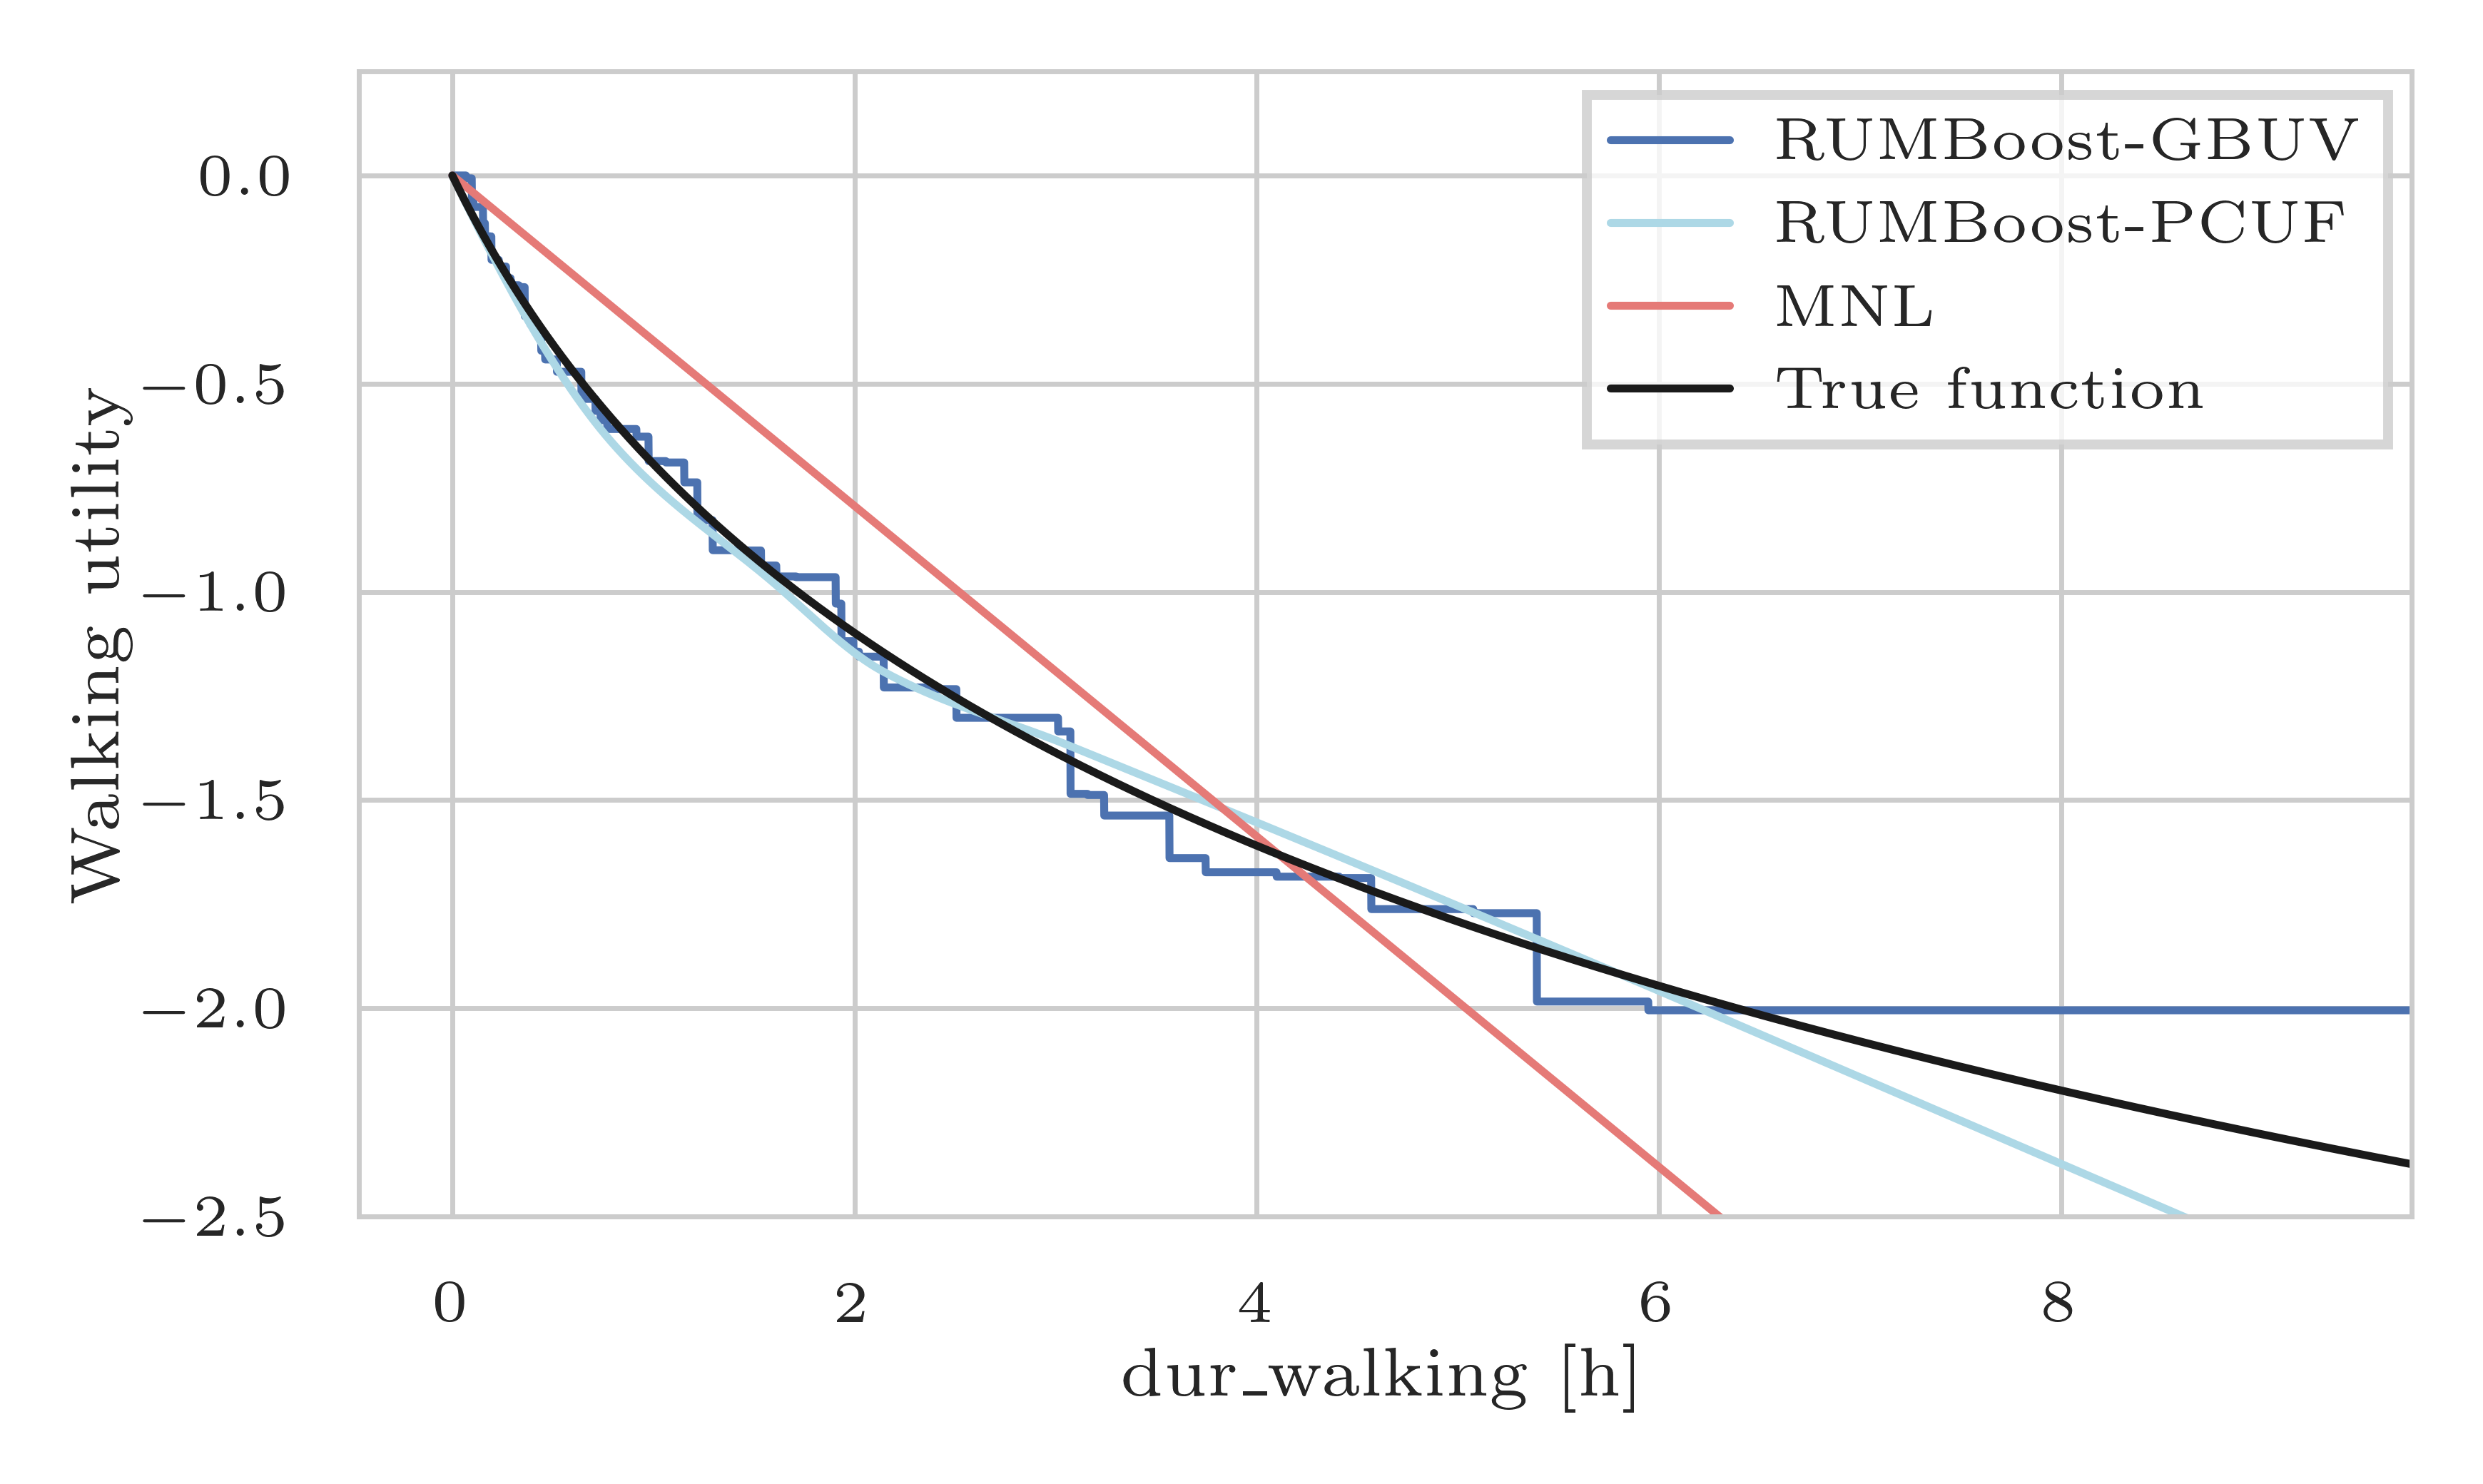

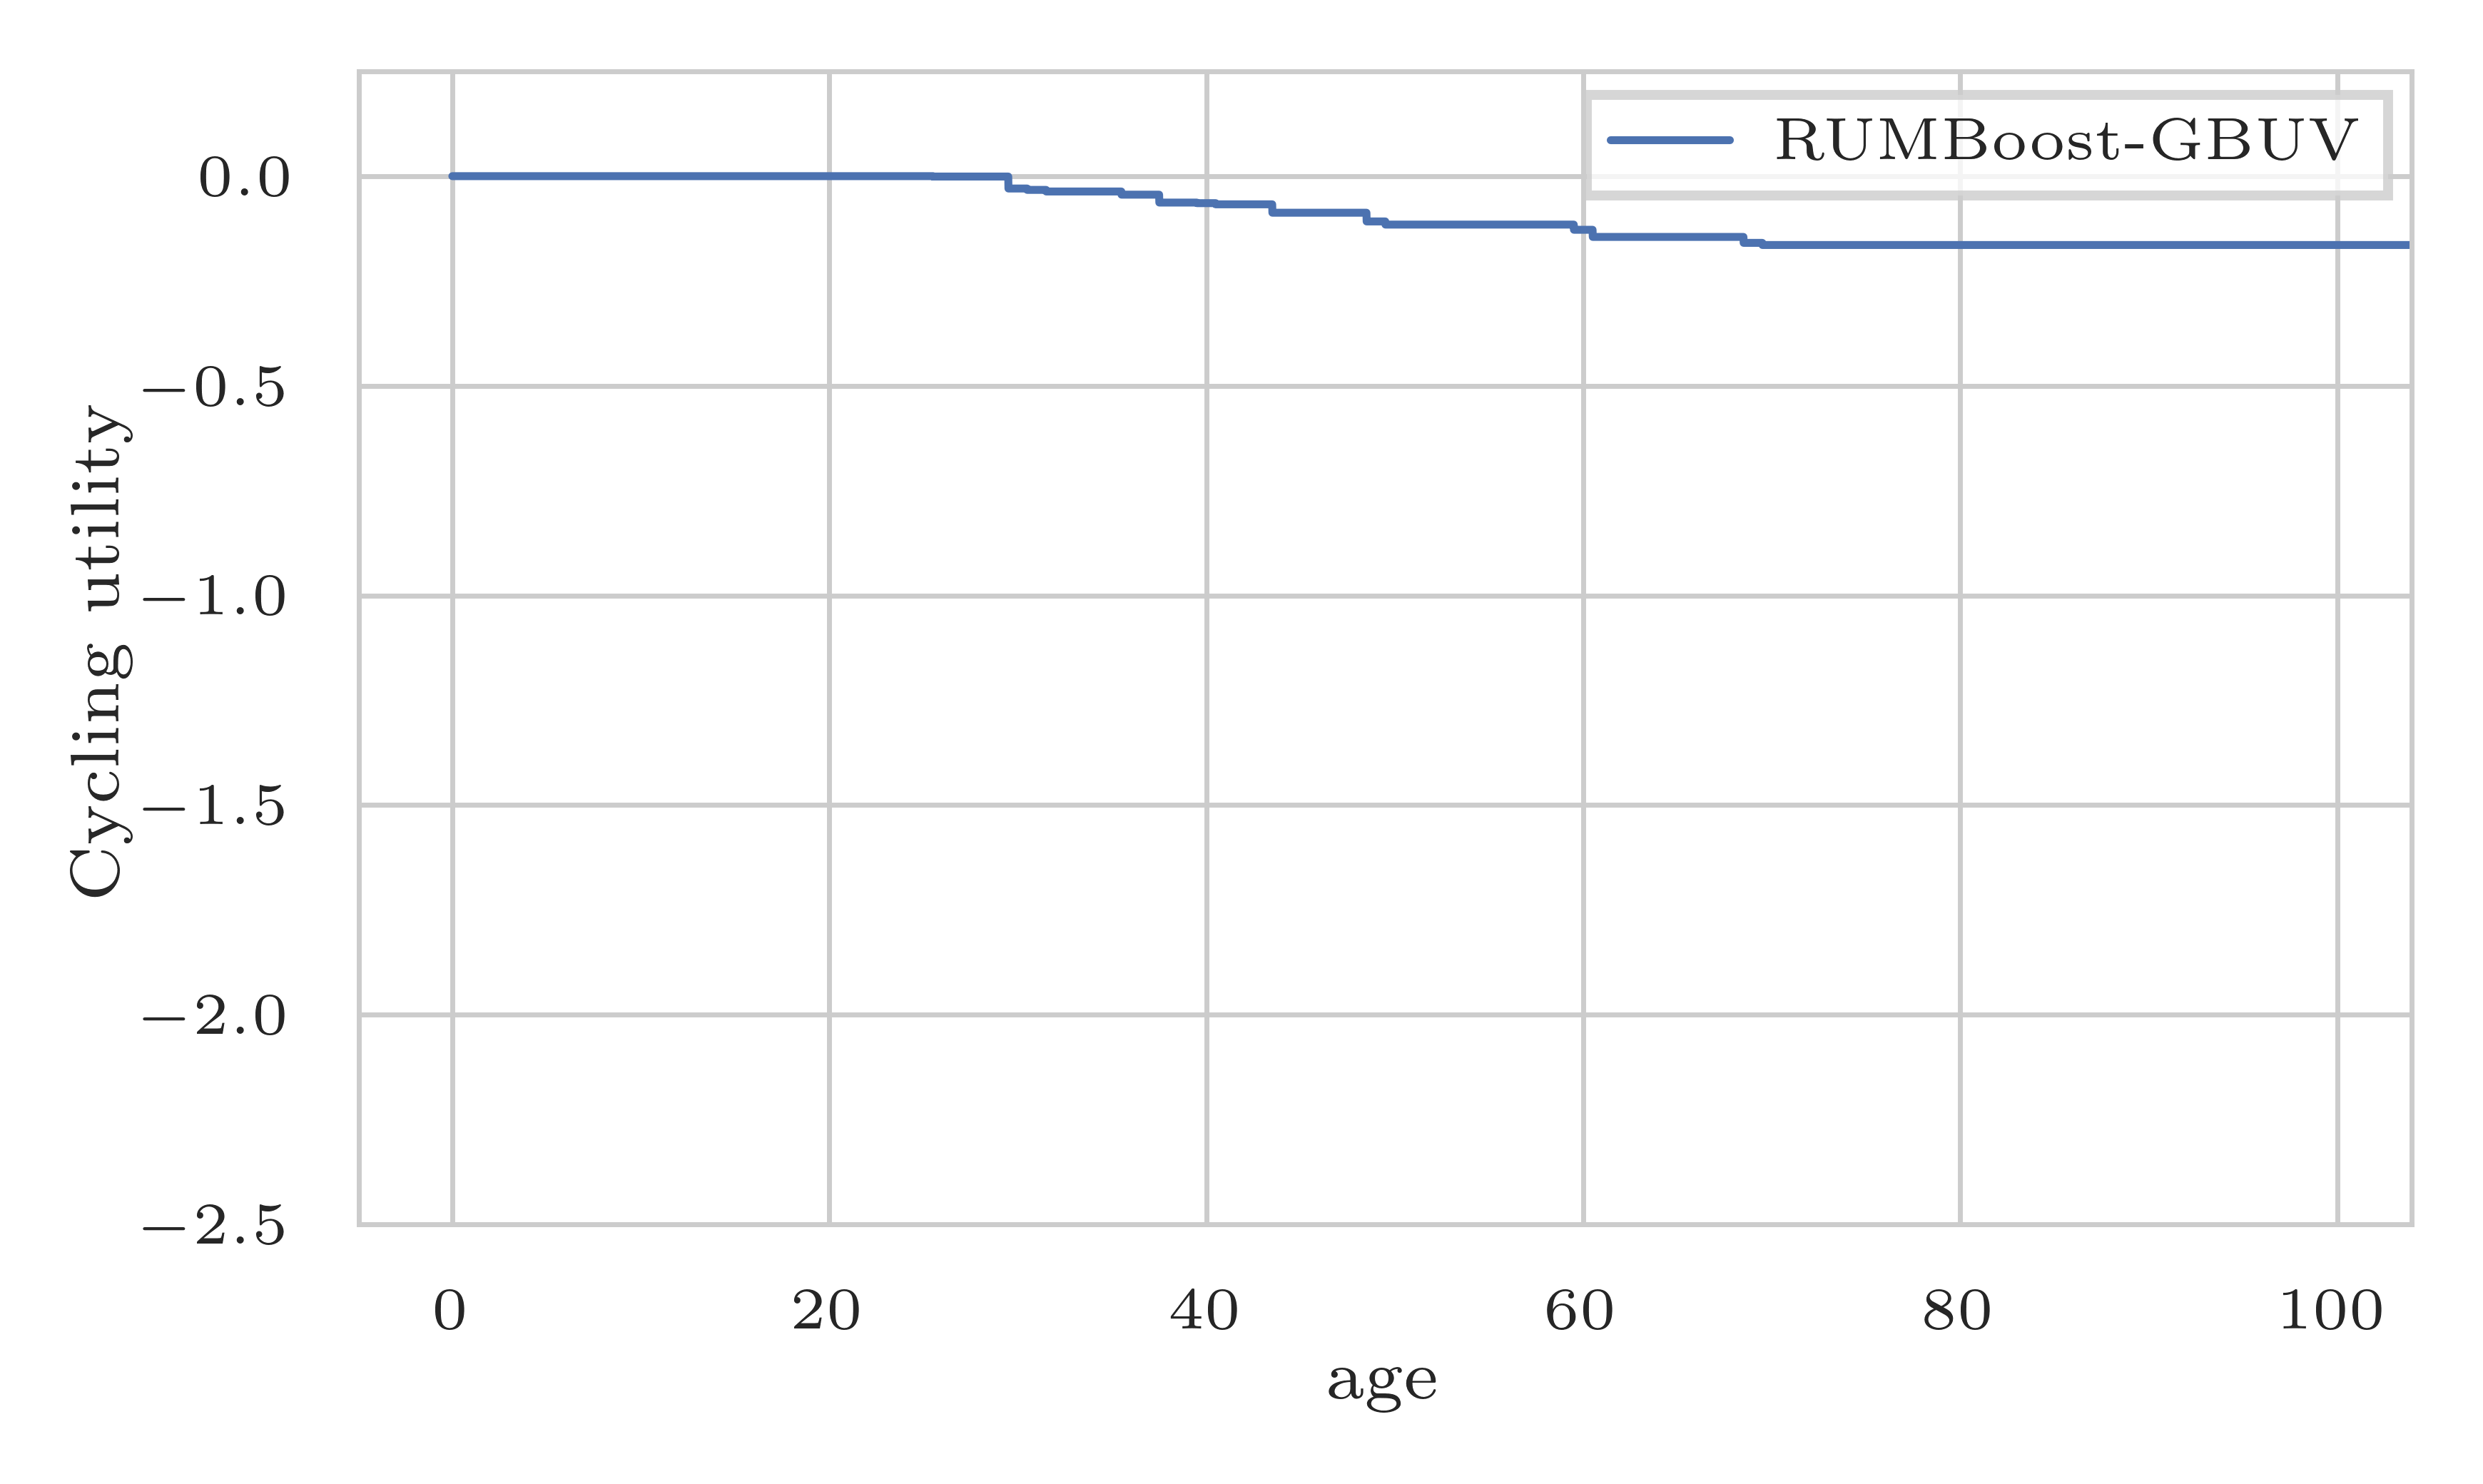

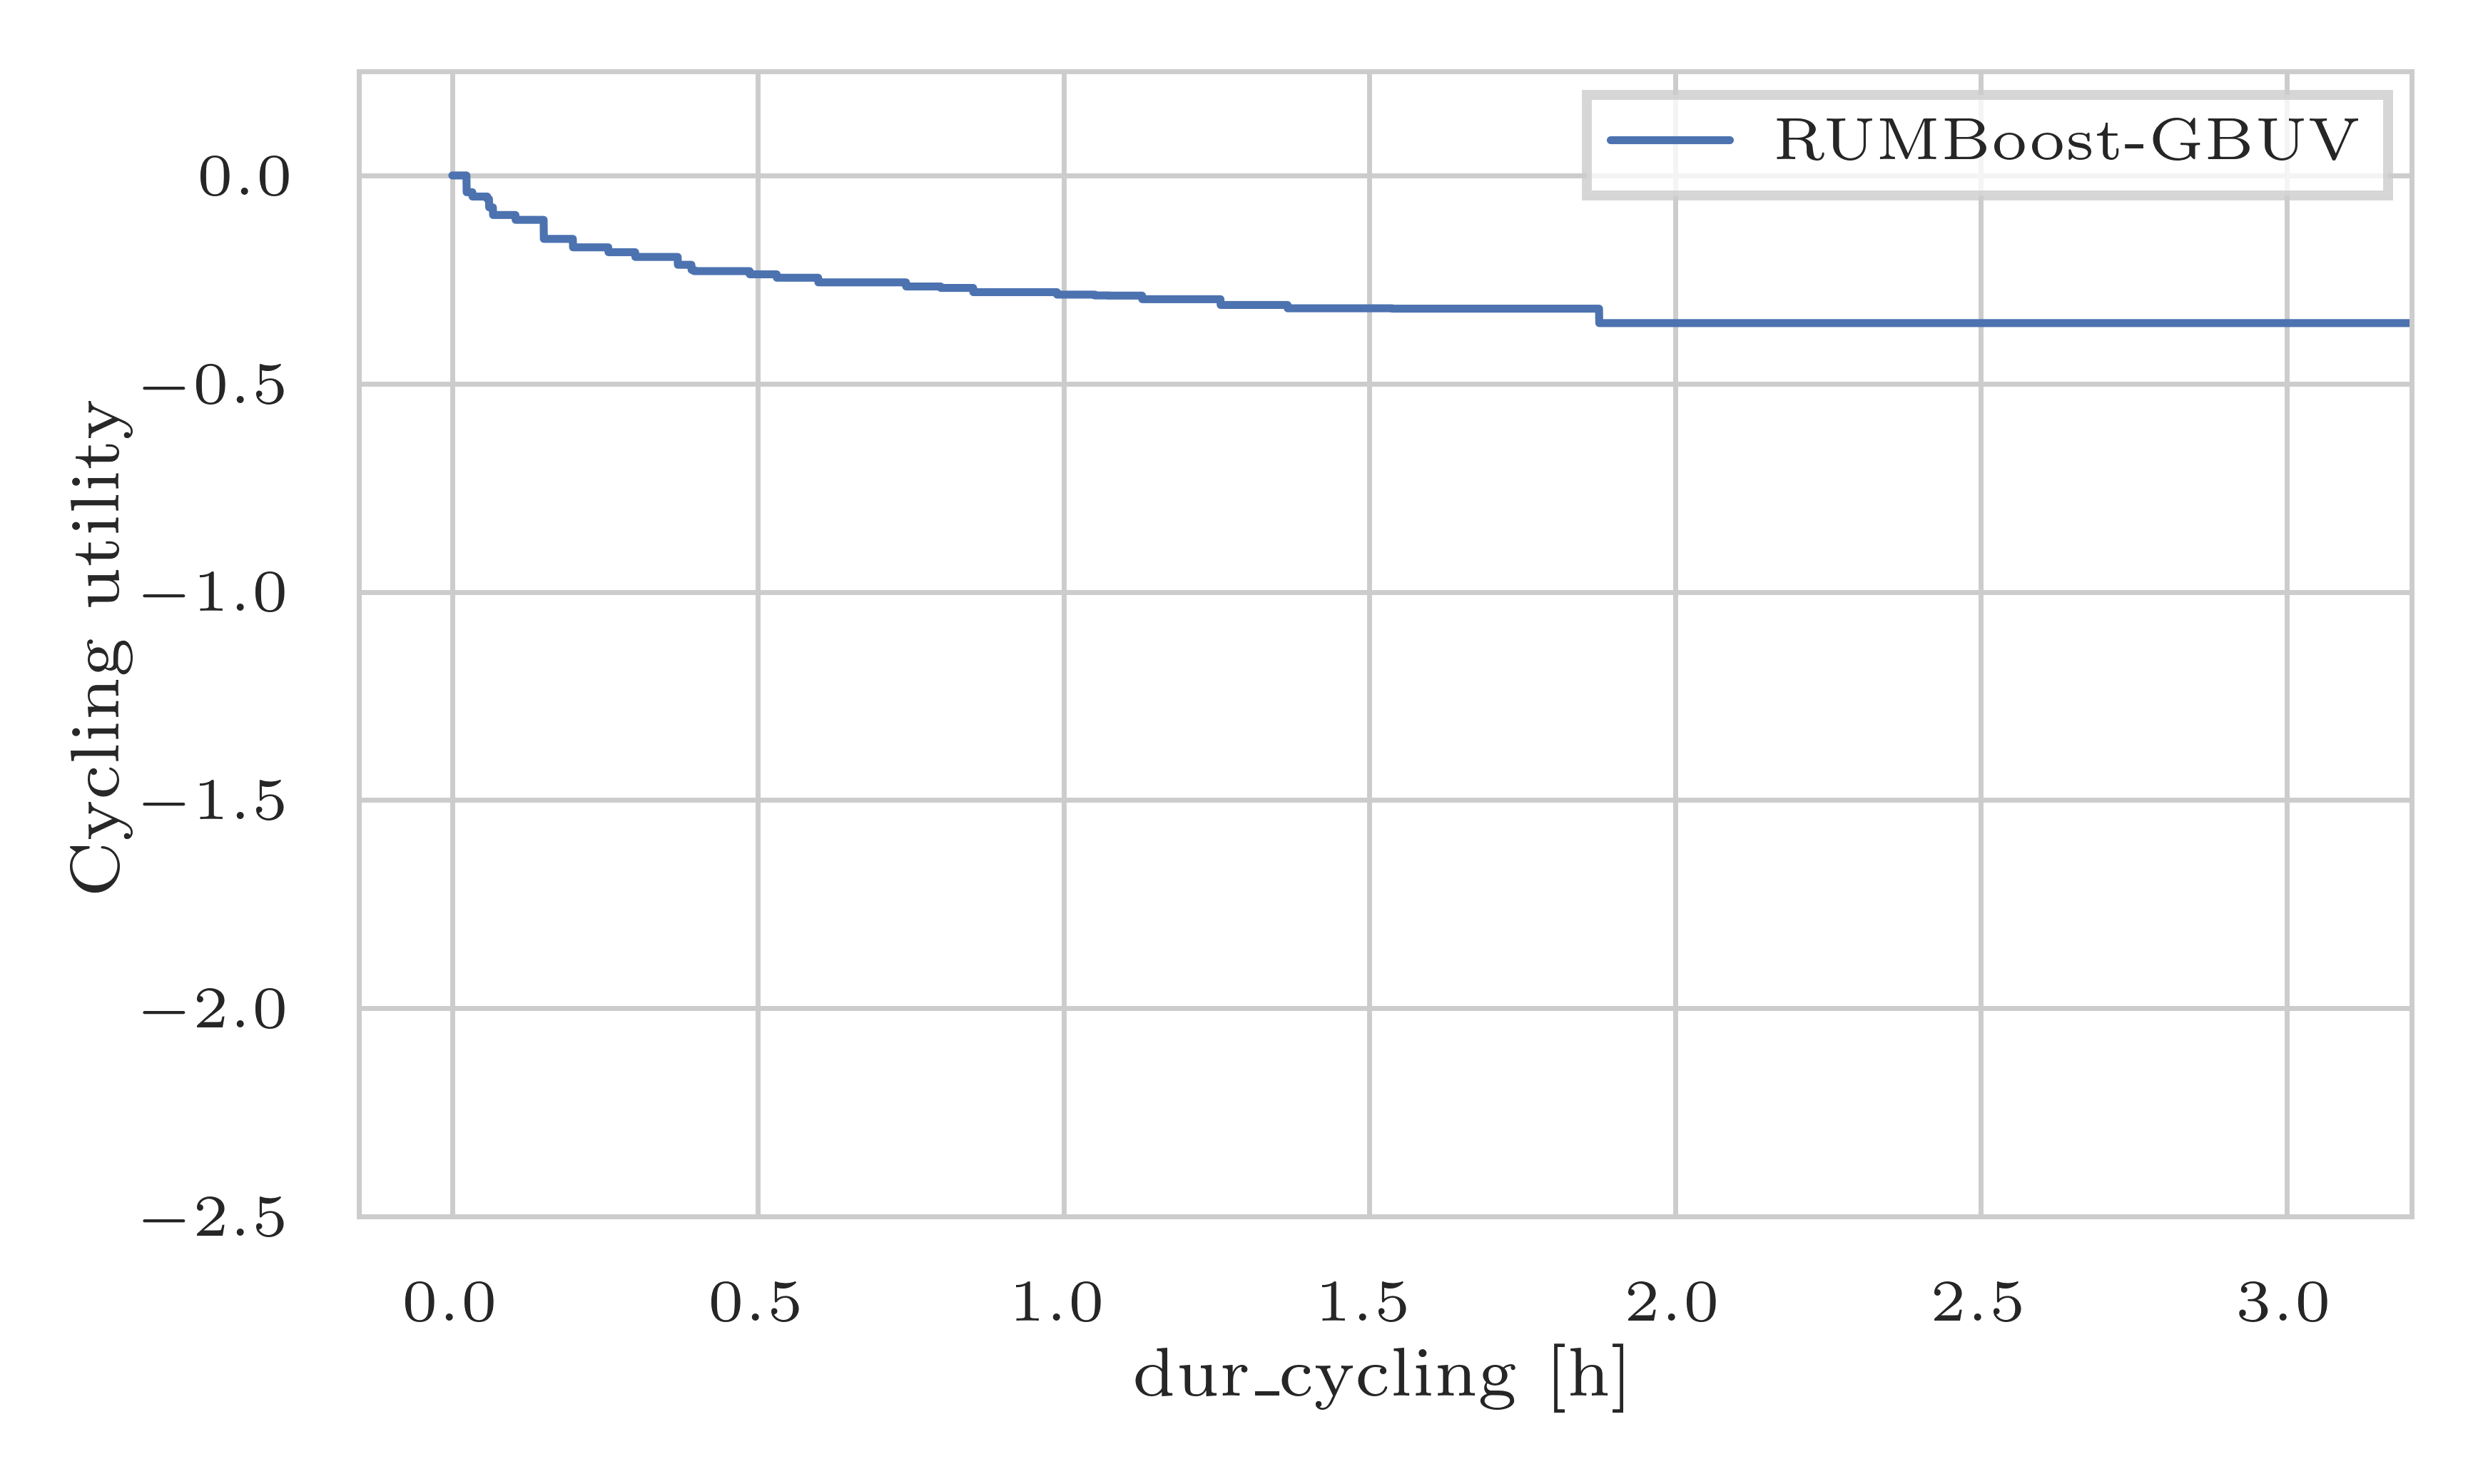

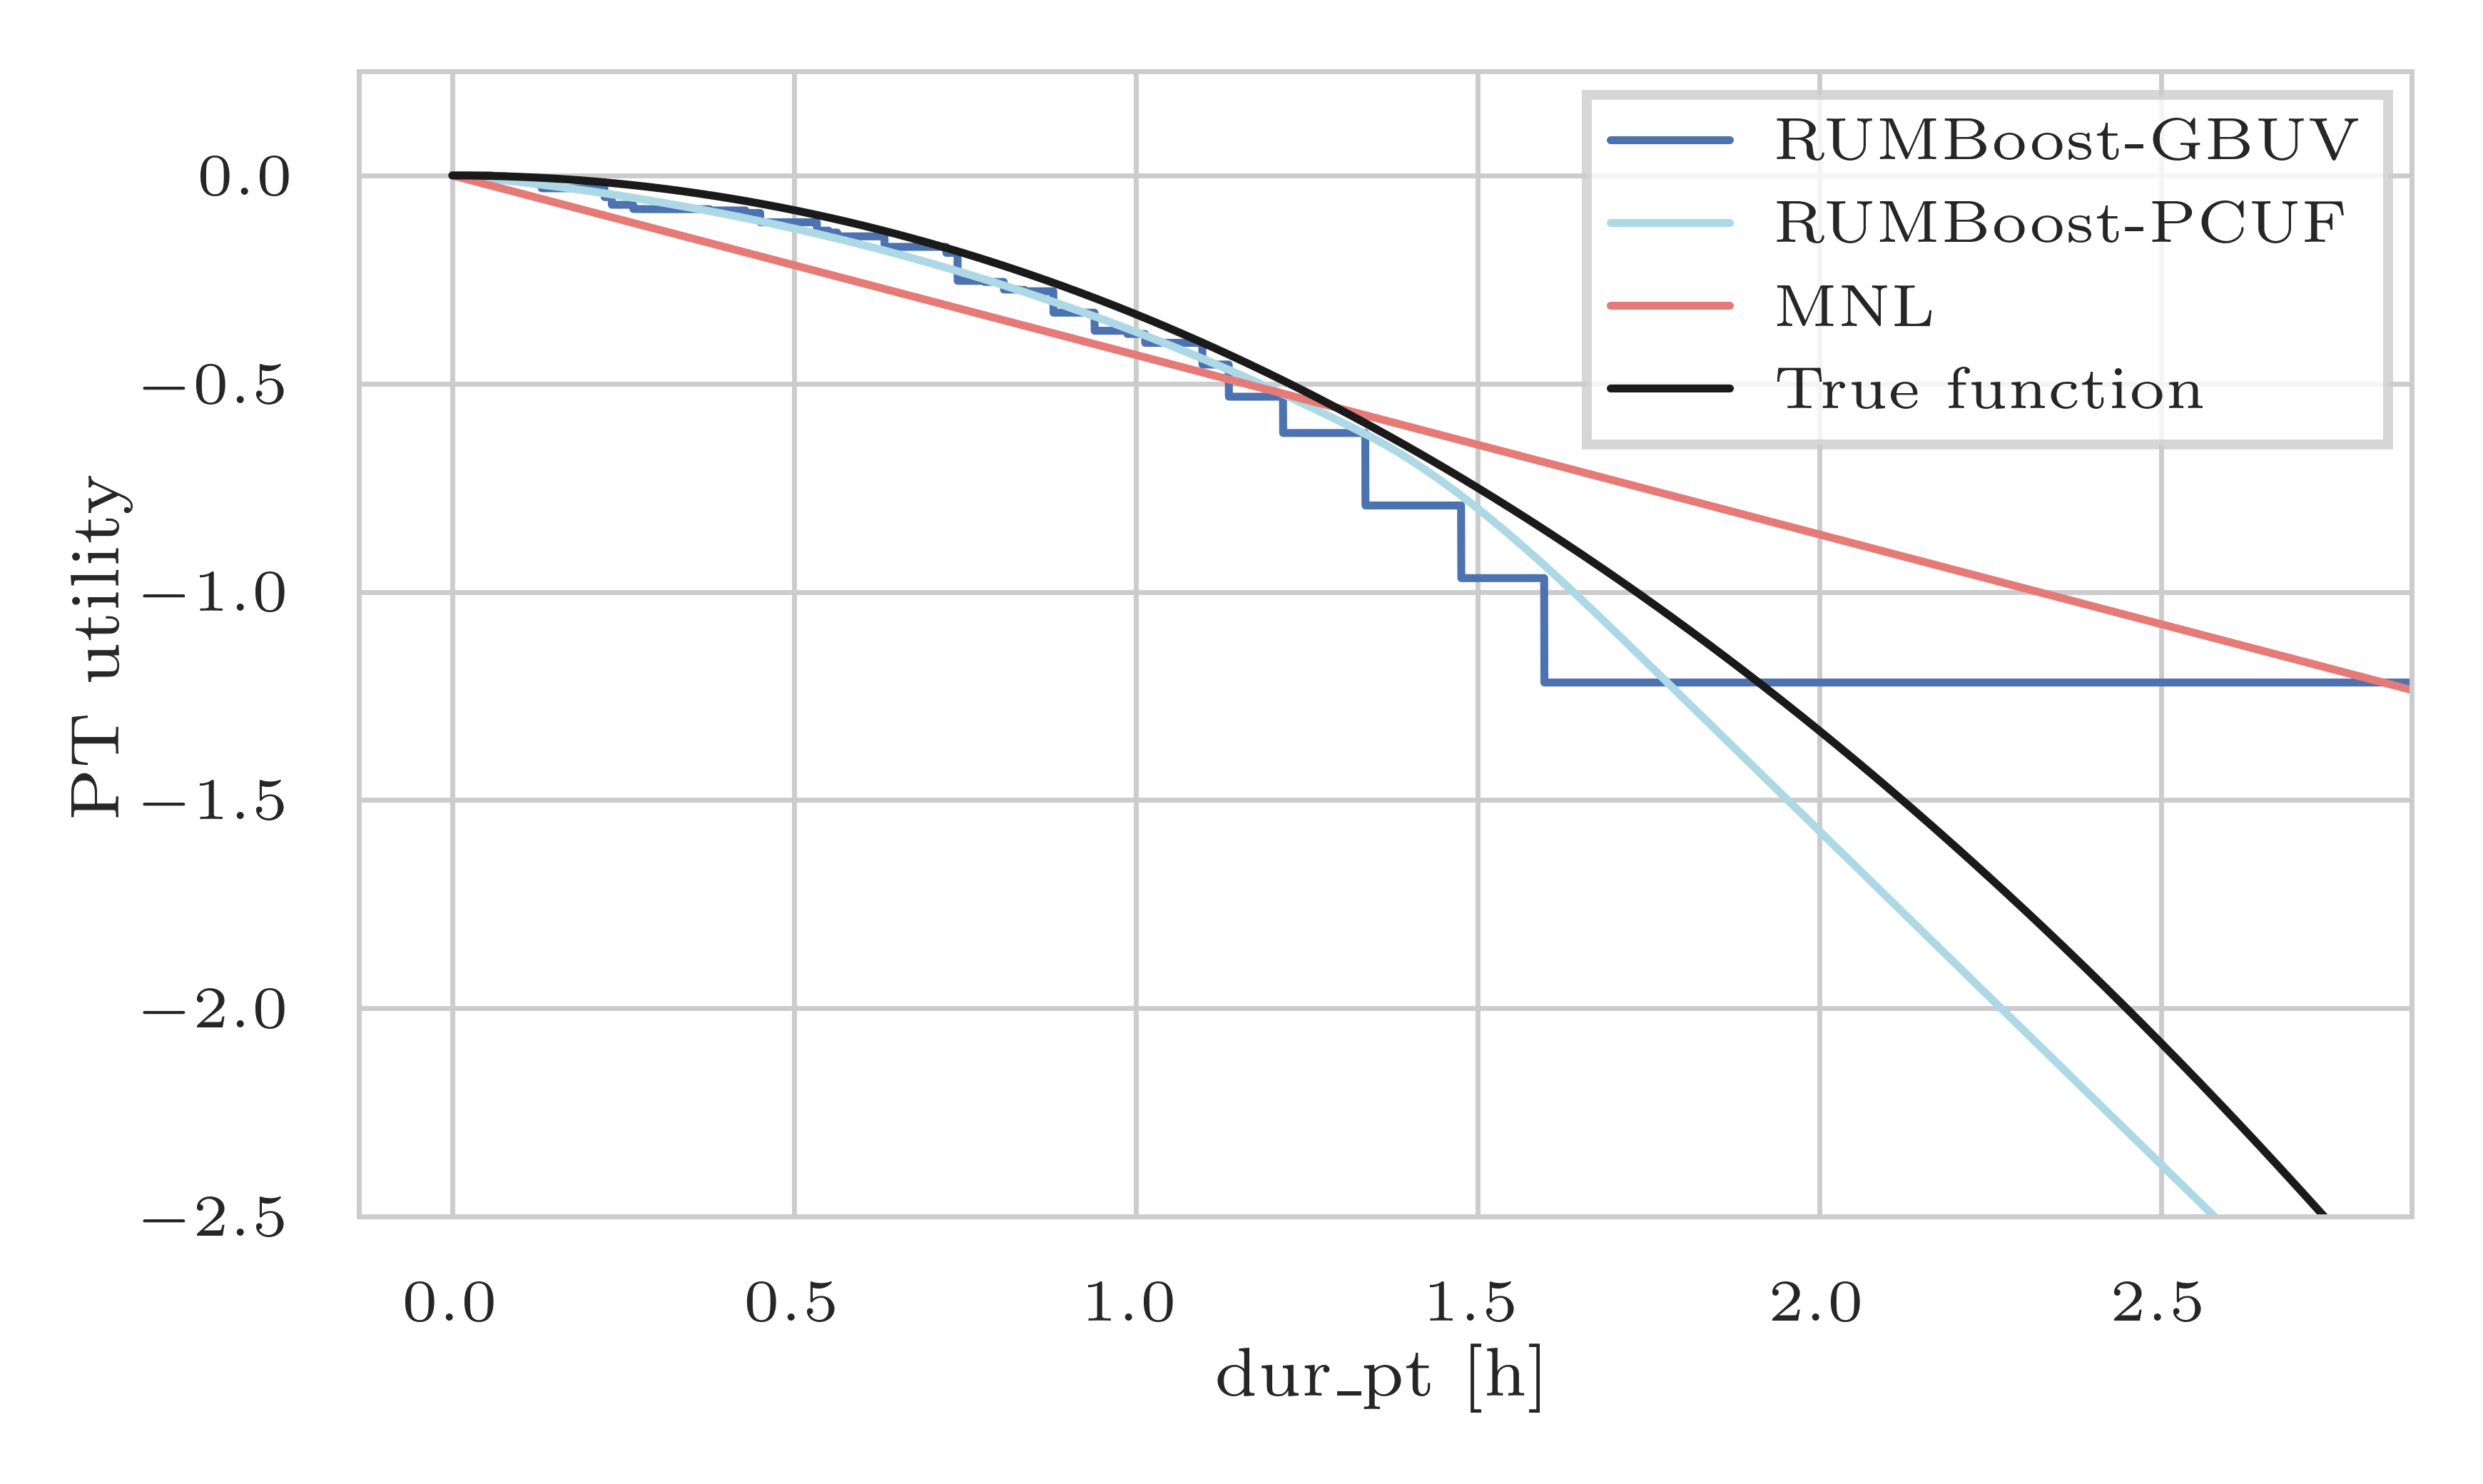

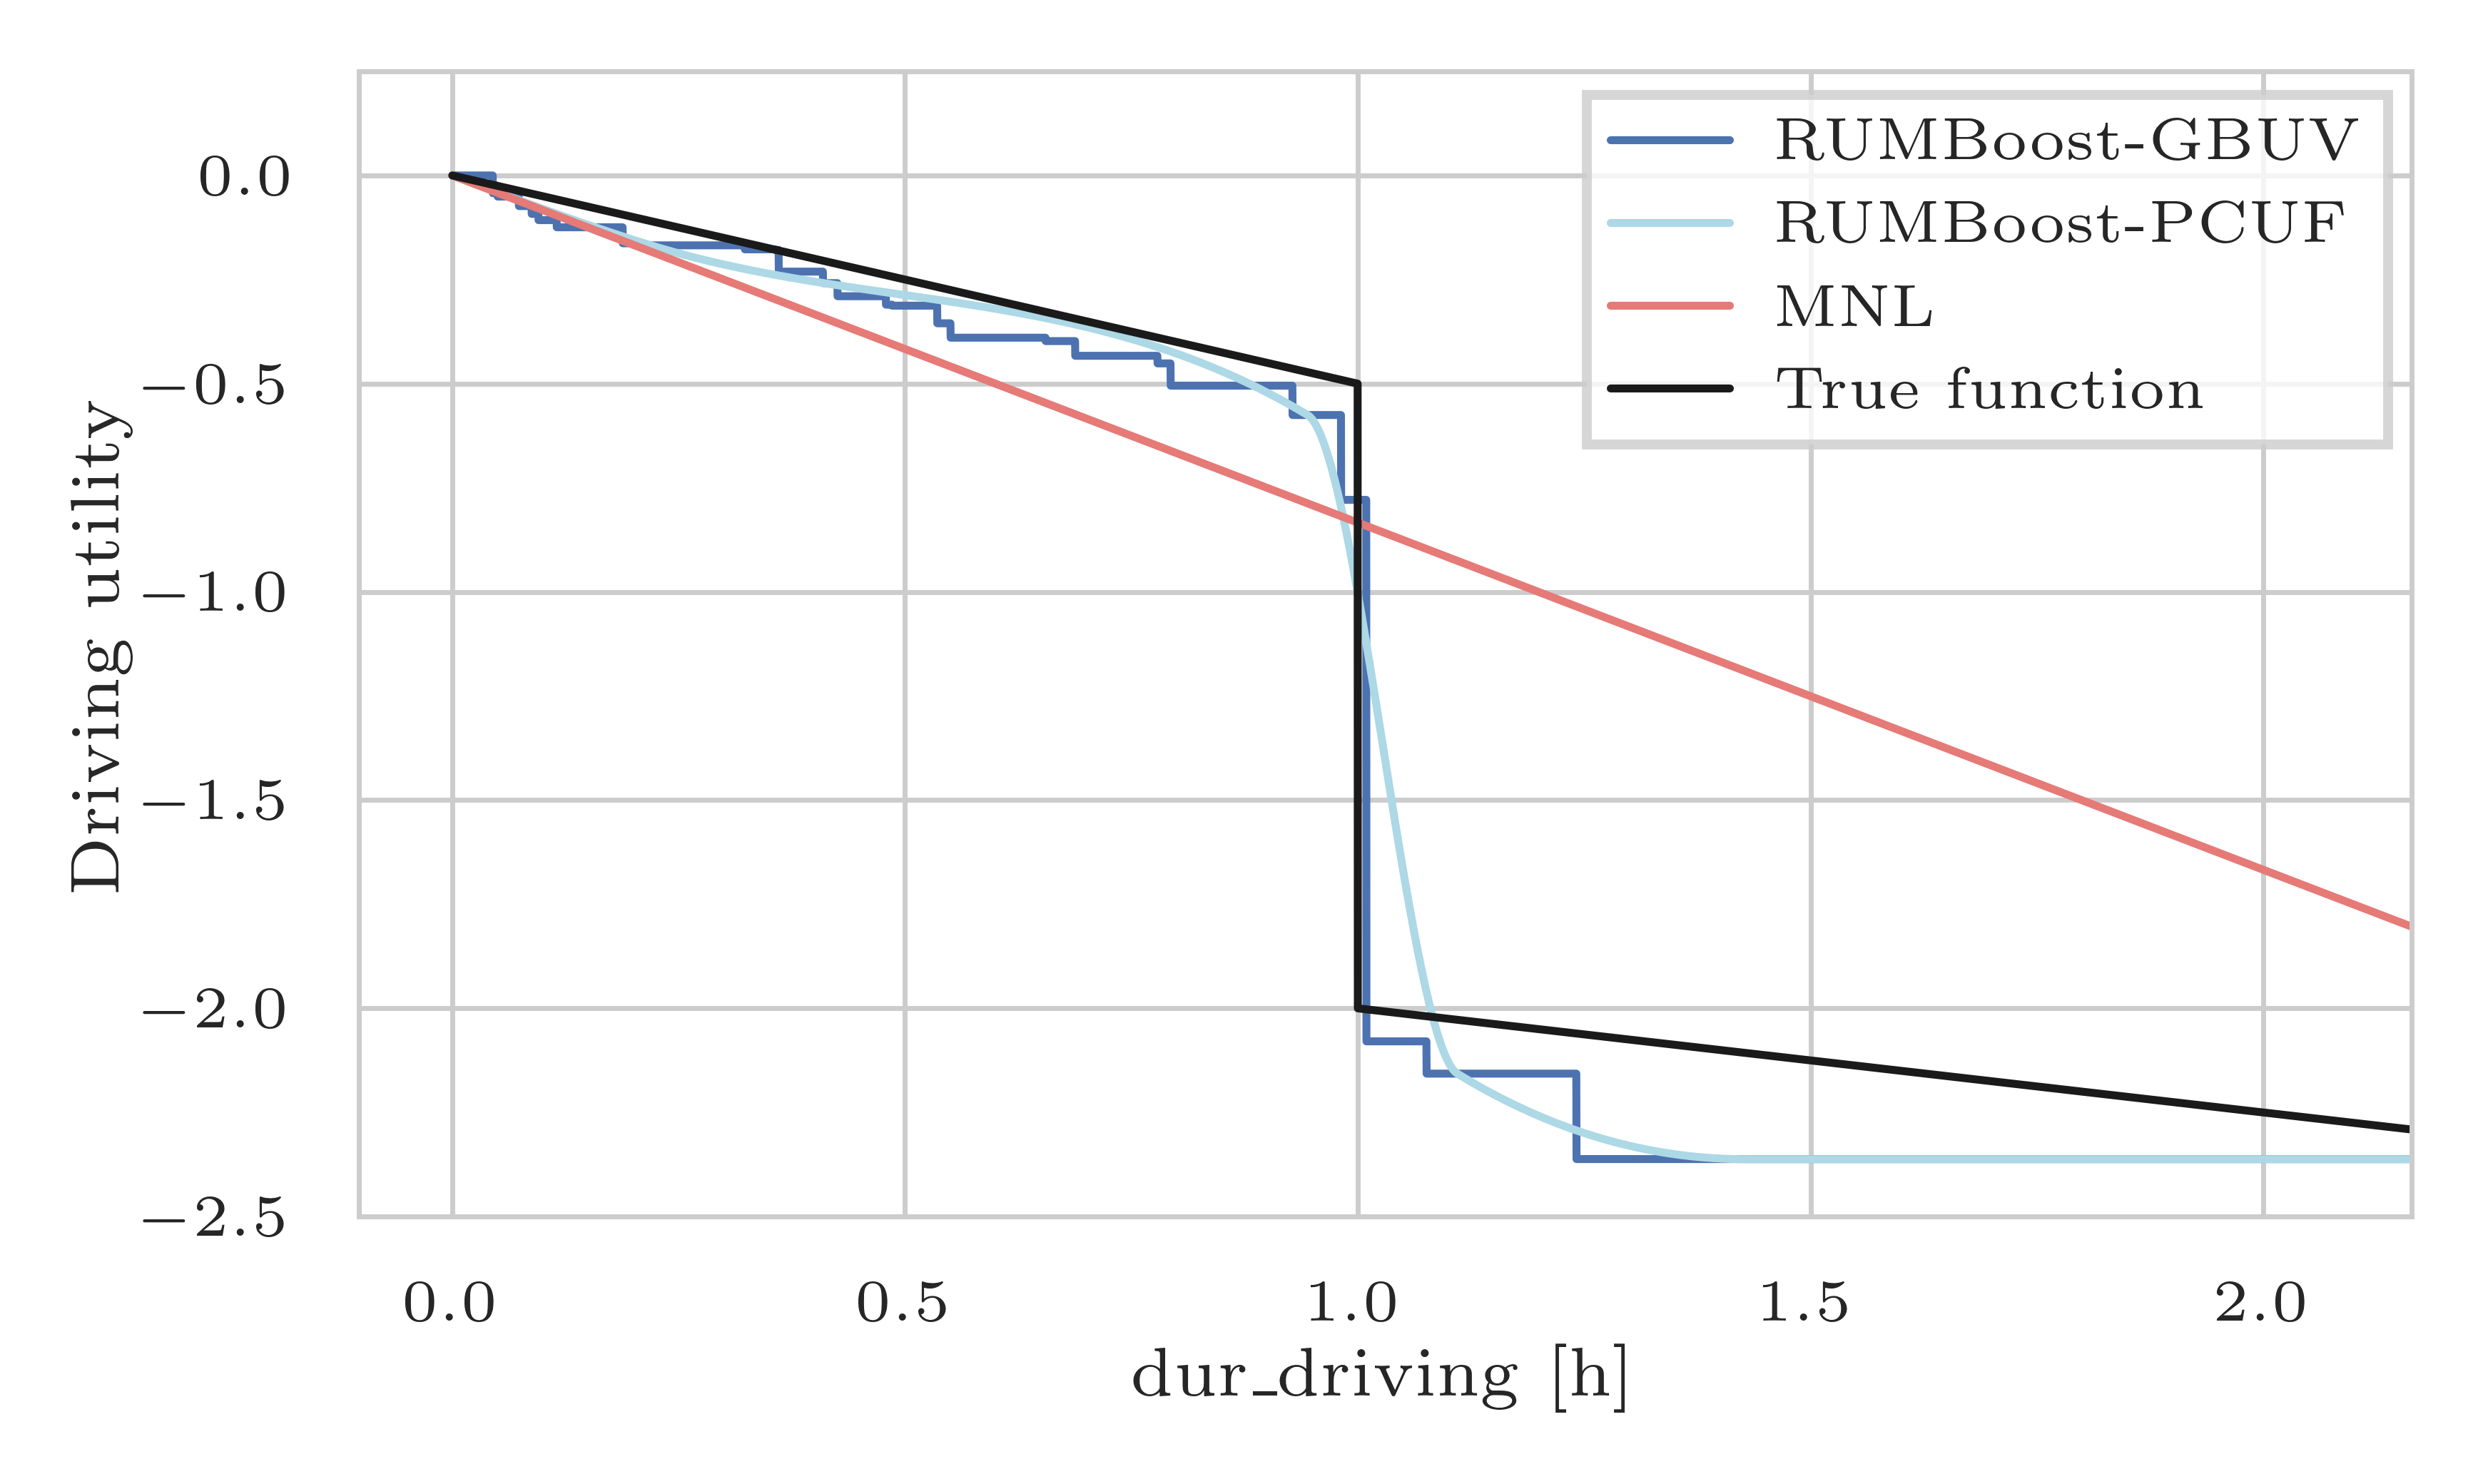

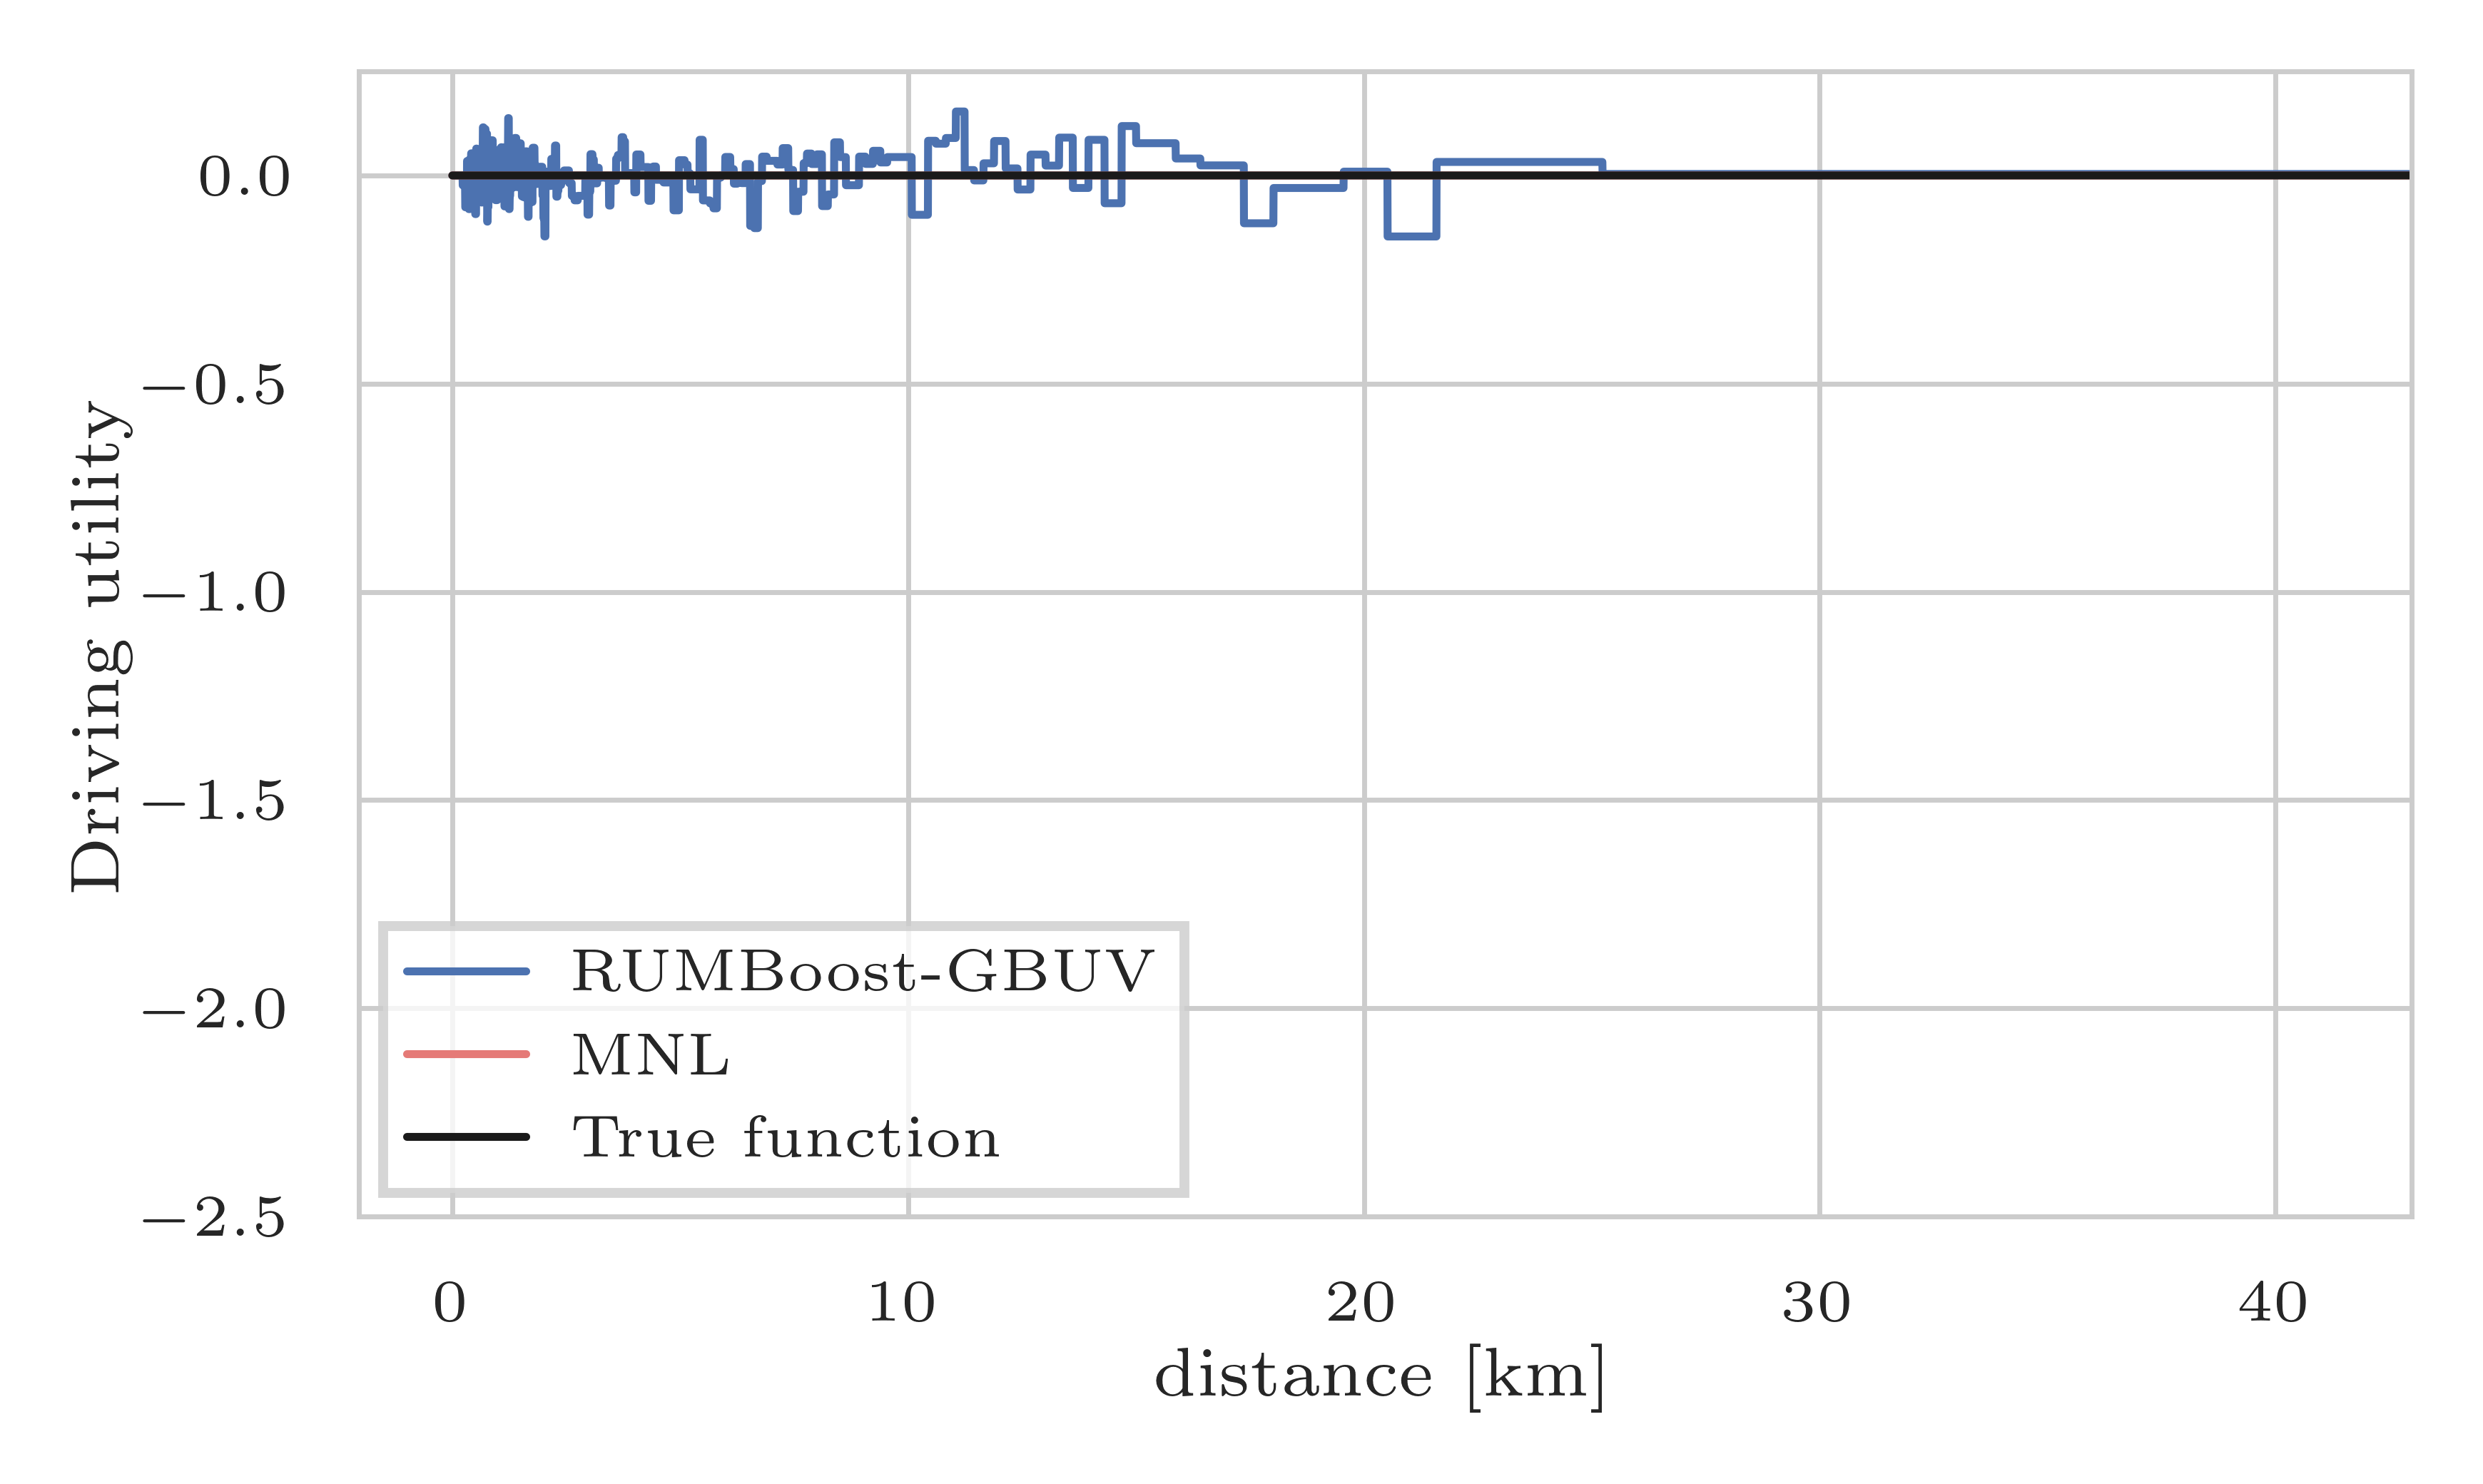

In [189]:

save_figure = True
with_mnl = True
with_noise = False
with_smoothing = True

dict_plot = {'dur_walking': log,
             #'dur_cycling': linear,
             'dur_pt': x_squared,
             'dur_driving':disc,
             'distance': null}

var_to_plot = ['dur_walking', 'dur_pt', 'dur_driving', 'distance']

var_smoothed = ['dur_walking', 'dur_pt', 'dur_driving']

#get and prepare weights
weights_arranged = rum_model.weights_to_plot_v2()
utility_names = {'0':'Walking', '1':'Cycling', '2':'PT', '3':'Driving'}

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True, 
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    # Use 14pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "axes.linewidth":0.5,
    "axes.labelpad": 1,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "legend.fancybox": False,
    "legend.edgecolor": "inherit",
    'legend.borderaxespad': 0.4,
    'legend.borderpad': 0.4,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.major.pad": 0.5,
    "ytick.major.pad": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 0.8
}
sns.set_theme(font_scale=1, rc=tex_fonts)
#sns.set_context(tex_fonts)
sns.set_style("whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    #"font.sans-serif": "Computer Modern Roman",
})


for u in weights_arranged:
    for i, f in enumerate(weights_arranged[u]):

        #create nonlinear plot
        x, non_lin_func = rum_model.non_lin_function(weights_arranged[u][f], 0, 1.05*max(dataset_train[f]), 10000)

        val_0 = non_lin_func[0]
        non_lin_func = [n - val_0 for n in non_lin_func]
        
        #plot parameters
        plt.figure(figsize=(3.49, 2.09), dpi=1000)
        #plt.title('Influence of {} on the predictive function ({} utility)'.format(f, utility_names[u]), fontdict={'fontsize':  16})
        plt.ylabel('{} utility'.format(utility_names[u]))

                            
        if 'dur' in f:
            plt.xlabel('{} [h]'.format(f))
        elif 'TIME' in f:
            plt.xlabel('{} [min]'.format(f))
        elif 'cost' in f:
            plt.xlabel('{} [£]'.format(f))
        elif 'distance' in f:
            plt.xlabel('{} [km]'.format(f))
        elif 'CO' in f:
            plt.xlabel('{} [chf]'.format(f))
        else:
            plt.xlabel('{}'.format(f))

        sns.lineplot(x=x, y=non_lin_func, color='b', label='RUMBoost-GBUV')

        if f in var_smoothed and with_smoothing:
            x_knots_temp, y_knots = data_leaf_value(x_knots_dict[u][f], weights_arranged[u][f])
            _, y_spline, _, x_knot, y_knot = monotone_spline(x, weights_arranged[u][f], num_splines=spline_collection[u][f], x_knots=x_knots_temp, y_knots=y_knots, linear_extrapolation=True)

            y_spline_norm = [y - y_spline[0] for y in y_spline]
            y_knot_norm = [y - y_spline[0] for y in y_knot]

            #splines
            sns.lineplot(x=x, y=y_spline_norm, color='#ADD8E6', label='RUMBoost-PCUF')

            #knots position
            #sns.scatterplot(x=x_knot, y=y_knot_norm, color='#ADD8E6', s=3, label='Spline knots')

        if f in betas_var.keys() and with_mnl:
            sns.lineplot(x=x, y=betas_var[f]*x, color ='#E57A77', label='MNL')

        if f in var_to_plot:
            sns.lineplot(x=x, y=dict_plot[f](x), color='k', label='True function')
        
        plt.xlim([0-0.05*np.max(dataset_train[f]), np.max(dataset_train[f])*1.05])
        plt.ylim([-2.5, 0.25])

        plt.tight_layout()

            
        if save_figure:
            if with_mnl:
                if with_noise:
                    plt.savefig('../Figures/RUMBoost/Synthetic experiment/{} utility, {} feature with MNL and noise.png'.format(utility_names[u], f))
                else:
                    plt.savefig('../Figures/RUMBoost/Synthetic experiment/{} utility, {} feature with MNL.png'.format(utility_names[u], f))
            else:
                if with_noise:
                    plt.savefig('../Figures/RUMBoost/Synthetic experiment/{} utility, {} feature with noise.png'.format(utility_names[u], f))
                else:
                    plt.savefig('../Figures/RUMBoost/Synthetic experiment/{} utility, {} feature .png'.format(utility_names[u], f))

        plt.show()

C:\Users\DAF1\AppData\Local\Temp\ipykernel_16076\1148802424.py:56: UserWarning: linewidths is ignored by contourf
  c_plot = axes[1].contourf(X, Y, contour_plot.T, levels=res, linewidths=0, cmap=customPalette, vmin=-4, vmax=0)
C:\Users\DAF1\AppData\Local\Temp\ipykernel_16076\1148802424.py:65: UserWarning: linewidths is ignored by contourf
  c_plot2 = axes[0].contourf(X, Y, -0.01*(X*Y), levels=res, linewidths=0, cmap=customPalette, vmin=-4, vmax=0)


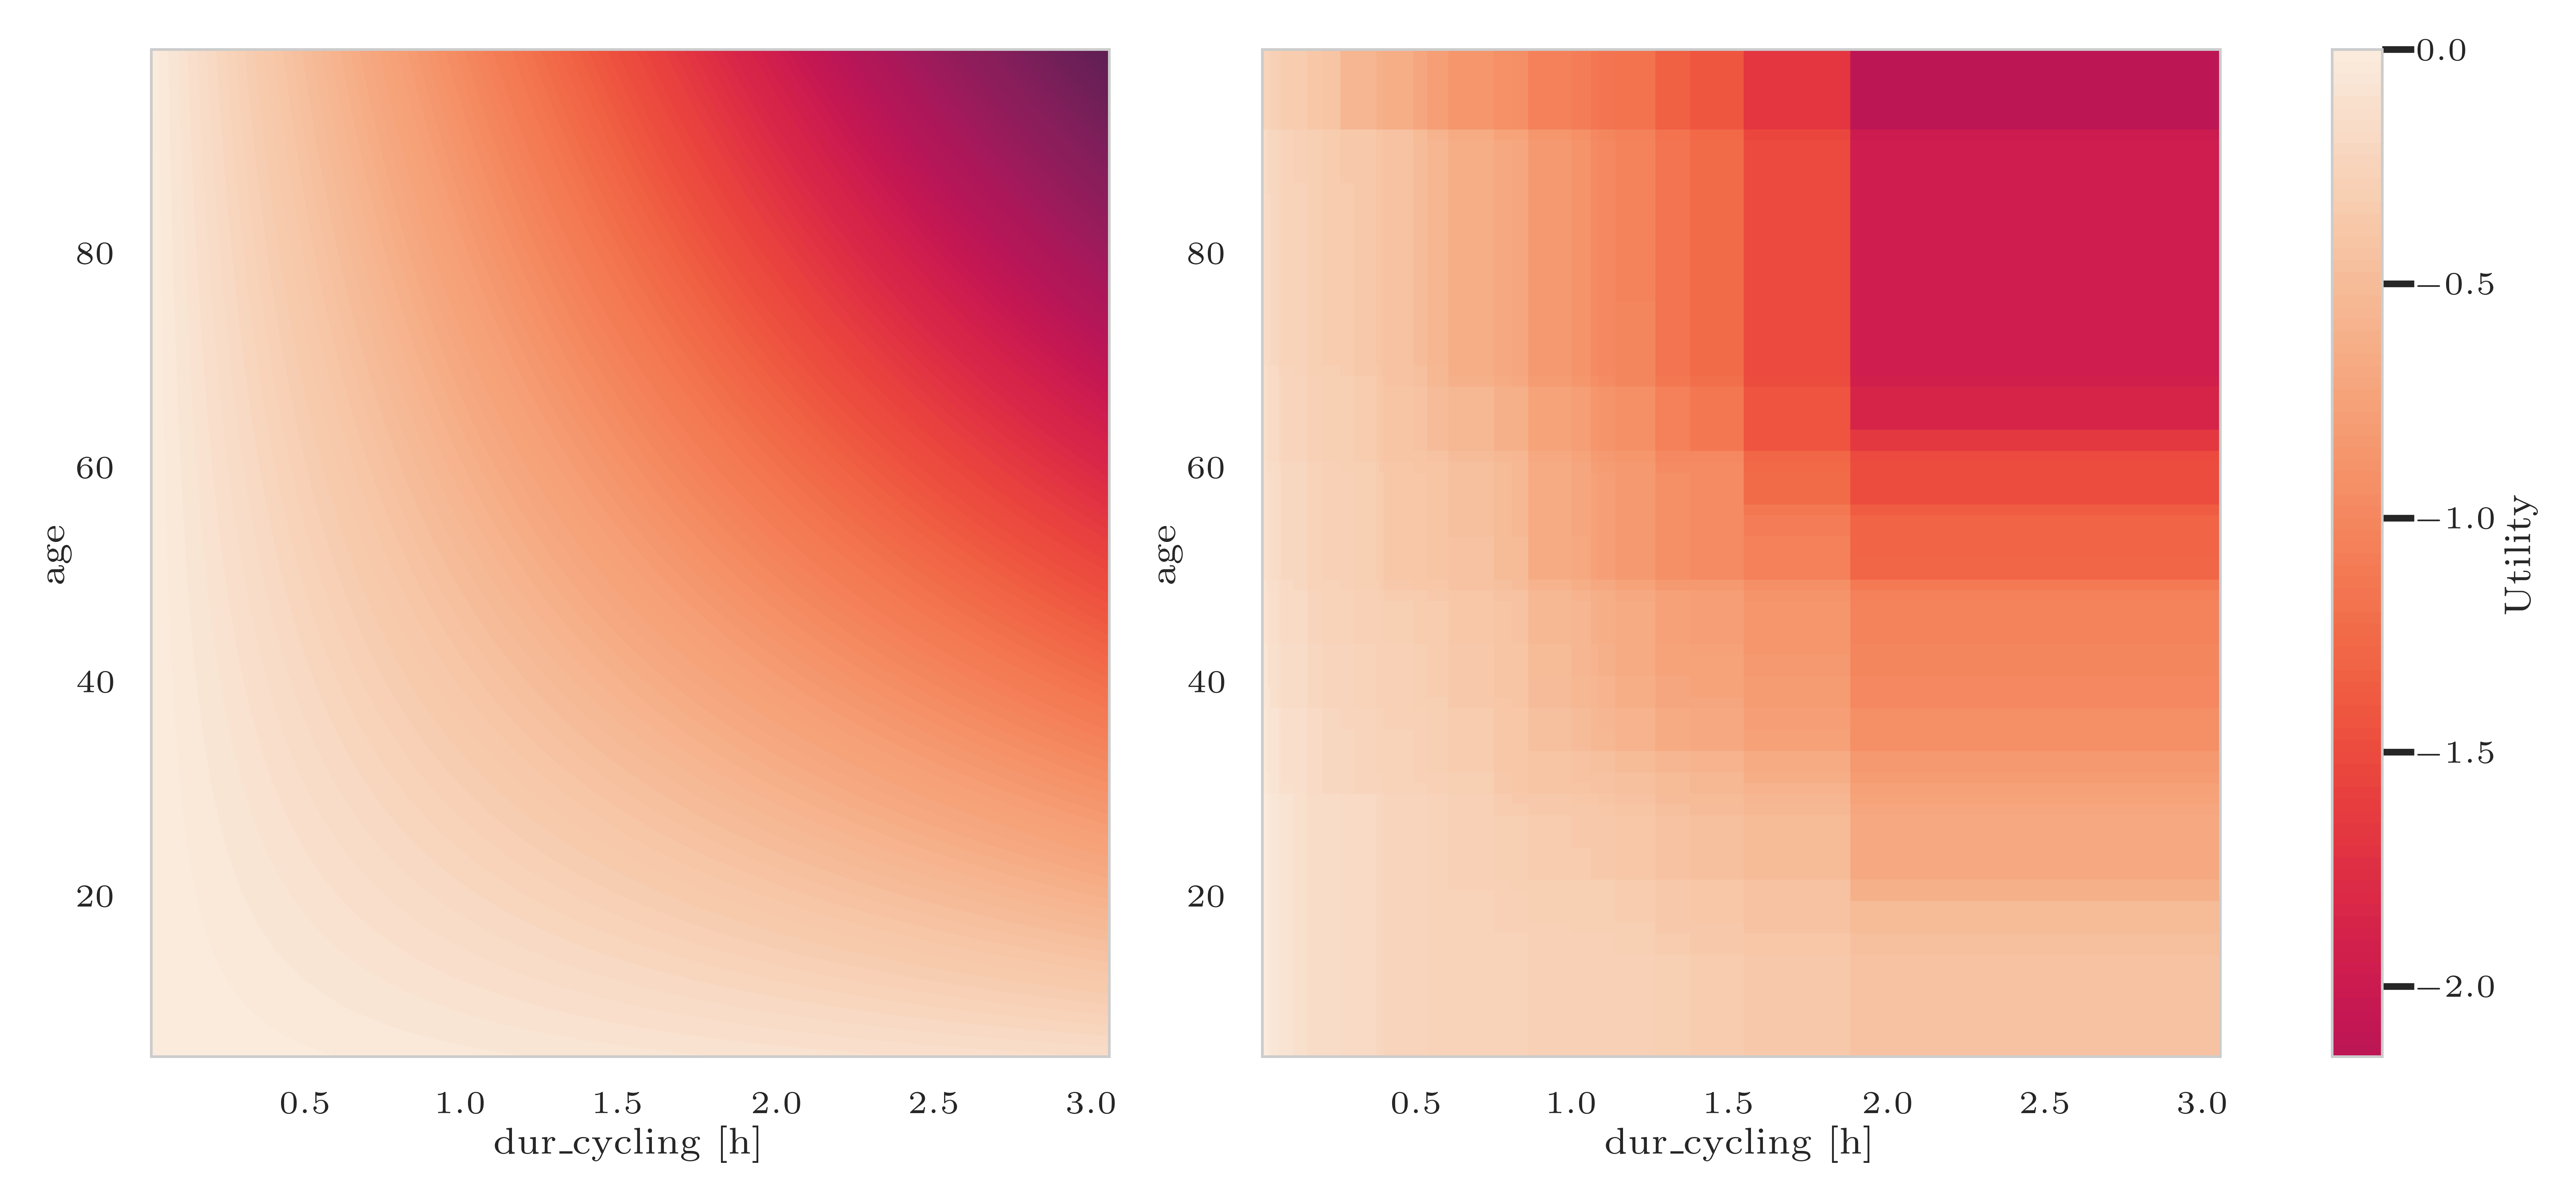

In [190]:
save_figure = True
with_noise = False

_, weights_2d, _ = rum_model.getweights_v2()
weights_ordered = rum_model.weights_to_plot_v2()

feature1 = 'dur_cycling'
feature2 = 'age'

name2 = "age" + "-" + "dur_cycling"
name1 = "dur_cycling" + "-" + "age"

min1 = dataset_train['dur_cycling'].min()
max1 = dataset_train['dur_cycling'].max()
min2 = dataset_train['age'].min()
max2 = dataset_train['age'].max()

num_points = 10000

x_vect = np.linspace(dataset_train['dur_cycling'].min(), dataset_train['dur_cycling'].max(), 10000)
y_vect = np.linspace(dataset_train['age'].min(), dataset_train['age'].max(), 10000)

for u in weights_2d.Utility.unique():
    weights_2d_util = weights_2d[weights_2d.Utility==u]
    contour_plot1 = rum_model.function_2d_v2(weights_2d_util[weights_2d_util.Feature==name1], x_vect, y_vect)
    contour_plot2 = rum_model.function_2d_v2(weights_2d_util[weights_2d_util.Feature==name2], y_vect, x_vect)

    contour_plot = contour_plot1 + contour_plot2.T

    if np.sum(contour_plot) == 0:
        continue

    if (feature1 in weights_ordered[str(u)].keys()) and (feature2 in weights_ordered[str(u)].keys()):
        _, feature1_alone = rum_model.non_lin_function(weights_ordered[str(u)][feature1], min1, max1, num_points)
        feature1_grid = np.repeat(feature1_alone, num_points).reshape((num_points, num_points))
        contour_plot += feature1_grid

        _, feature2_alone = rum_model.non_lin_function(weights_ordered[str(u)][feature2], min2, max2, num_points)
        feature2_grid = np.repeat(feature2_alone, num_points).reshape((num_points, num_points)).T
        contour_plot += feature2_grid

    contour_plot -= contour_plot.max()

    colors = ['#F5E5E2', '#DF7057', '#A31D04']
    # Set your custom color palette
    customPalette = sns.set_palette(sns.color_palette(colors, as_cmap=True))

    if np.sum(contour_plot) != 0:
        X, Y = np.meshgrid(x_vect, y_vect)
        fig, axes = plt.subplots(1, 2, figsize=(6.58,3), layout='constrained', dpi=1000)

        #fig.suptitle('Impact of {} and {} on the utility function'.format(feature1, feature2))

        res = 100

        c_plot = axes[1].contourf(X, Y, contour_plot.T, levels=res, linewidths=0, cmap=customPalette, vmin=-4, vmax=0)

       # axes[1].set_title(f'RUMBoost')


        #axes.set_title(f'{utility_names[int(u)]}')
        axes[1].set_xlabel(f'{feature1} [h]')
        axes[1].set_ylabel(f'{feature2}')

        c_plot2 = axes[0].contourf(X, Y, -0.01*(X*Y), levels=res, linewidths=0, cmap=customPalette, vmin=-4, vmax=0)

        #axes[0].set_title(f'True function')


        #axes.set_title(f'{utility_names[int(u)]}')
        axes[0].set_xlabel(f'{feature1} [h]')
        axes[0].set_ylabel(f'{feature2}')

        cbar = fig.colorbar(c_plot, ax = axes, ticks=[-2.5, -2, -1.5, -1, -0.5, 0])
        cbar.ax.set_ylabel('Utility')

        if save_figure:
            if with_noise:
                plt.savefig('../Figures/RUMBoost/Synthetic experiment/cycling utility, {} and {} features with noise.png'.format(feature1, feature2))
            else:
                plt.savefig('../Figures/RUMBoost/Synthetic experiment/cycling utility, {} and {} features.png'.format(feature1, feature2))

        plt.show()